### Make necessary imports

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Import CIFAR-10 Dataset

Cifar10 is a classic dataset for deep learning, consisting of 32×32 images belonging to 10 different classes, such as dog, frog, truck, ship, and so on. Cifar10 resembles MNIST — both have 10 classes and tiny images

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

### Understanding Dataset

In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


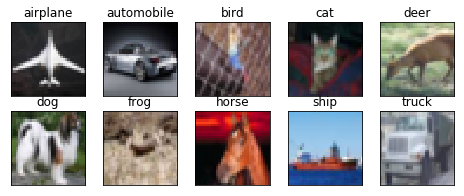

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Import nn_utils: Library for commonly used utilities

In [5]:
!git clone https://github.com/ashxjain/nn_utils.git

Cloning into 'nn_utils'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 42 (delta 16), reused 32 (delta 8), pack-reused 0
Unpacking objects: 100% (42/42), done.


### Image Preprocessing

In [42]:
from nn_utils import preprocessing

# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

print(batchX.min(), batchX.max())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.019683057 1.0061224
(50000, 32, 32, 3) -1.6605131e-06 1.0000001
-1.9892113 2.1267967


In [0]:
# create generator that centers pixel values
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train = batchy
y_test = batch_testy

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)                        

In [0]:
# Define the model

def ConvBN(x, c, kernel_size=3, strides=(1, 1), bn_mom=0.99, bn_eps=0.001):
  x = Convolution2D(c, (3, 3), strides=strides, padding='same', use_bias=False) (x)
  x = (BatchNormalization(momentum=bn_mom, epsilon=bn_eps)) (x)
  x = (Activation('relu')) (x)
  return x

def layer(x):
  x = ConvBN(x, 64)
  x = MaxPooling2D (pool_size=(2, 2))(x)
  x1 = ConvBN(x, 64)
  x1 = ConvBN(x1, 64)
  x1 = Add()([x1, x])
  return x1


from keras.layers import Input
from keras.models import Model
from keras.layers import Add, BatchNormalization, Dropout, Activation, Lambda

def get_model():
  input =  Input(shape=(32,32,3))
  x = ConvBN(input, 64)
  #Layer1
  x = layer(x)
  x = ConvBN(x, 64)
  x = MaxPooling2D (pool_size=(2, 2))(x)
  #Layer2
  x = layer(x)
  x = GlobalMaxPooling2D()(x)
  x = Dense(10, activation='softmax') (x)
  x = Lambda(lambda x: x *0.125)(x)

  model = Model(inputs=input, outputs=x)

  return model

### HyperParameters

In [0]:
BATCH_SIZE = 512 #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
EPOCHS = 24 #@param {type:"slider", min:0, max:100, step:1}

### Find Optimal LR Range

In [36]:
from nn_utils import lr_utils

lr_finder = lr_utils.LR_Finder(
    start_lr=1e-5,
    end_lr=10,
    step_size=np.ceil(
        (X_train.shape[0])/BATCH_SIZE
    )
)

model = get_model()

# Save initial weights, as we are finding Optimal LR for this initial weight
model.save_weights('initial_weights.hd5')

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Ensure that number of epochs = 1 when calling fit()
model.fit(X_train, Y_train, epochs=1, batch_size=BATCH_SIZE, callbacks=[lr_finder])

Epoch 1/1
50000/50000 [==============================] - 20s 406us/step - loss: 3.3187 - acc: 0.2197


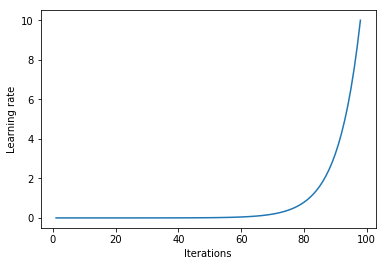

In [37]:
lr_finder.plot_lr()


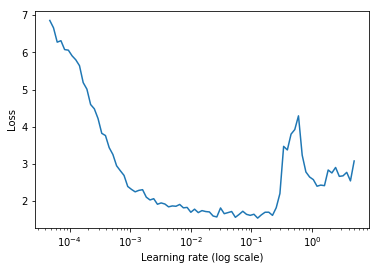

In [38]:
lr_finder.plot_loss()

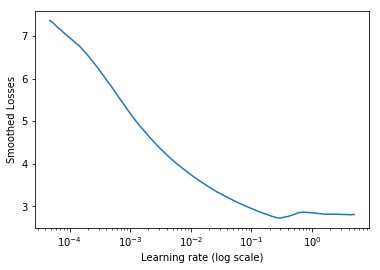

In [39]:
lr_finder.plot_smoothed_loss()

* From above, we can see optimal LR is somewhere between 0.01 & 0.2
* Mostly it increase slightly after 0.2
* Will use 0.1 as max LR value

In [45]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from nn_utils import lr_utils

checkpoint = ModelCheckpoint(
    "assignment_12_best_weights.hdf5",
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

lr_manager = lr_utils.OneCycleLR(max_lr=0.2, maximum_momentum=0.9, verbose=True, batch_size=BATCH_SIZE)

callbacks_list = [lr_manager, checkpoint]

# Load the model & Compile it
model = get_model()

# Load saved initial weights, as we are using Optimal LR found for this initial weight
model.load_weights('initial_weights.hd5')

# These values will be overridden by the above callback
optimizer = SGD(lr=0.04, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

DATA_AUGMENTATION = True

# train the model
start = time.time()

# Train the model
if DATA_AUGMENTATION:
  datagen = ImageDataGenerator(
      width_shift_range=4,
      height_shift_range=4,
      horizontal_flip=True,
      fill_mode='reflect',
      preprocessing_function=preprocessing.get_random_eraser(v_l=0, v_h=1, p=0.2)
  )

  model_info = model.fit_generator(
      datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
      steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
      nb_epoch = EPOCHS,
      validation_data = (X_test, Y_test),
      callbacks=callbacks_list, 
      verbose=1)
else:
  model_info = model.fit(
          X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_test, Y_test),
          shuffle=True,
          verbose=1,
          callbacks=callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, validation_data=(array([[[..., callbacks=[<nn_utils..., verbose=1, epochs=24)`


Epoch 1/24
 3/97 [..............................] - ETA: 1:50 - loss: 6.0480 - acc: 0.1354

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.644387). Check your callbacks.
  % delta_t_median)


97/97 [==============================] - 31s 317ms/step - loss: 2.3849 - acc: 0.2893 - val_loss: 1.8260 - val_acc: 0.3457
 - lr: 0.03650 - momentum: 0.90 

Epoch 00001: val_acc improved from -inf to 0.34570, saving model to assignment_12_best_weights.hdf5
Epoch 2/24
97/97 [==============================] - 27s 277ms/step - loss: 1.4829 - acc: 0.4839 - val_loss: 1.6340 - val_acc: 0.4221
 - lr: 0.05318 - momentum: 0.89 

Epoch 00002: val_acc improved from 0.34570 to 0.42210, saving model to assignment_12_best_weights.hdf5
Epoch 3/24
97/97 [==============================] - 29s 294ms/step - loss: 1.1456 - acc: 0.5969 - val_loss: 1.3933 - val_acc: 0.5344
 - lr: 0.06986 - momentum: 0.89 

Epoch 00003: val_acc improved from 0.42210 to 0.53440, saving model to assignment_12_best_weights.hdf5
Epoch 4/24
97/97 [==============================] - 28s 293ms/step - loss: 0.9294 - acc: 0.6722 - val_loss: 0.9272 - val_acc: 0.6703
 - lr: 0.08653 - momentum: 0.88 

Epoch 00004: val_acc improved from 0.

In [46]:
print("LR Range : ", min(lr_manager.history['lr']), max(lr_manager.history['lr']))
print("Momentum Range : ", min(lr_manager.history['momentum']), max(lr_manager.history['momentum']))

LR Range :  0.00028461538 0.2
Momentum Range :  0.85 0.9


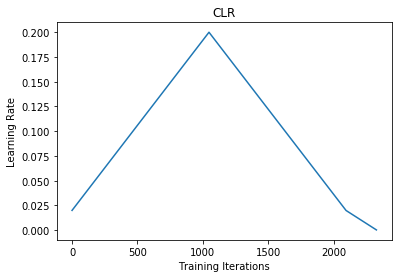

In [47]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(lr_manager.history['lr'])
plt.show()

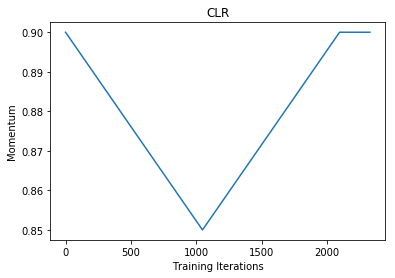

In [48]:
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("CLR")
plt.plot(lr_manager.history['momentum'])
plt.show()

### Save the model weights
* Better to save the model weights
* Following downloads it to your local computer
* You can upload it to Google Drive and give downloadable link

In [0]:
from google.colab import files
files.download("assignment_12_best_weights.hdf5")